# OLS Regression of Event Driven Trading

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FOMCDrift/root/src")
from Regression import Regression

## Full Sample Prior (No Lagged Params)

We'll regress the average return of days -3 to -1, and then regress them against day -4. Also one regression per each security.

In [6]:
def _ols_regression(df: pd.DataFrame, variable: str):

    df_tmp = (df.query(
        "variable == @variable").
        drop(columns = ["variable"]))

    df_exog = (df_tmp.query(
        "day == -4").
        drop(columns = ["date", "day", "PX_bps"]).
        fillna(0))

    df_endog = (df_tmp.query(
        "-3 <= day <= -1")
        [["event", "PX_bps"]].
        groupby("event").
        agg("mean"))

    df_combined = (df_endog.merge(
        right = df_exog, how = "inner", on = ["event"]).
        set_index("event"))

    model = (sm.OLS(
        endog = df_combined.PX_bps,
        exog  = sm.add_constant(df_combined.drop(columns = ["PX_bps"]))).
        fit())
    
    return model

In [7]:
def get_ols() -> list: 

    df_raw    = (Regression().prep_regression())
    df_good   = df_raw.query("day != [0,1]")
    variables = df_good.variable.drop_duplicates().to_list()
    models    = [
        {
            "exog" : variable,
            "model": _ols_regression(df_good, variable)} 
        for variable in variables]

    return models

models = get_ols()

In [8]:
def _get_params(model) -> pd.DataFrame: 

    df_params = (model["model"].params.to_frame(
        name = "param").
        reset_index().
        rename(columns = {"index": "exog"}))

    df_fitted = (model["model"].pvalues.to_frame(
        name = "pvalue").
        reset_index().
        rename(columns = {"index": "exog"}))

    df_out = (df_params.merge(
        right = df_fitted, how = "inner", on = ["exog"]).
        assign(endog = model["exog"]))

    return df_out

df_params = pd.concat([_get_params(model) for model in models])

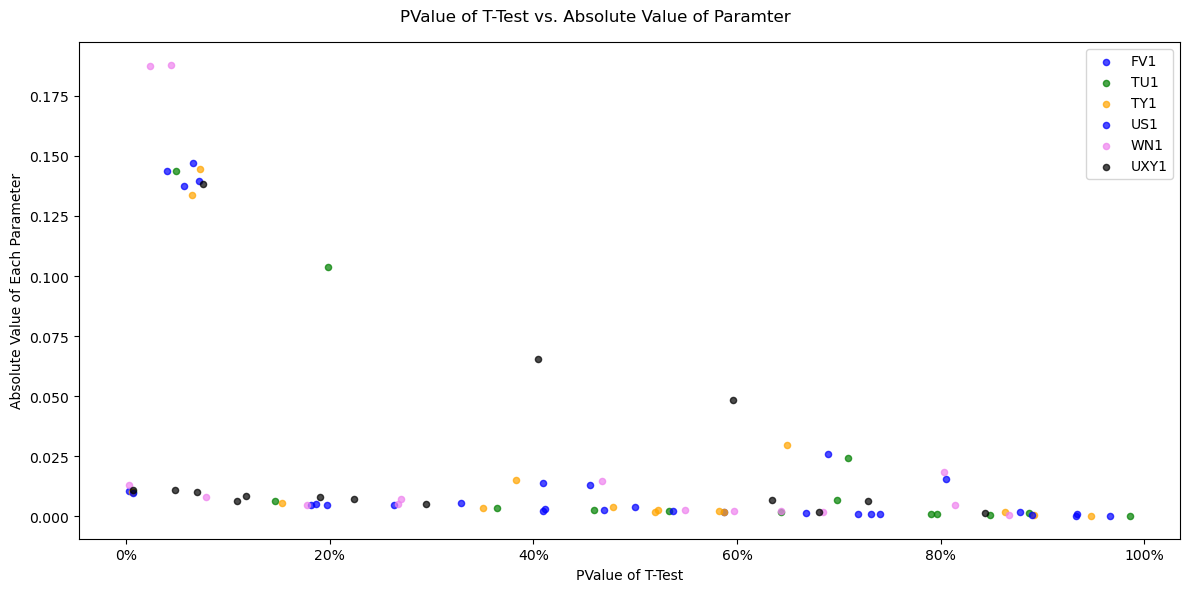

In [9]:
def plot_pvalues(df_params: pd.DataFrame) -> plt.Figure: 

    endogs = {
        "FV1" : "blue",
        "TU1" : "green",
        "TY1" : "orange",
        "US1" : "blue",
        "WN1" : "violet",
        "UXY1": "black"}
    
    fig, axes = plt.subplots(figsize = (12,6))
    for endog in endogs.keys():
    
        (df_params.query(
            "endog == @endog").
            assign(param = lambda x: np.abs(x.param)).
            plot(
                ax     = axes,
                kind   = "scatter",
                x      = "pvalue",
                y      = "param",
                color  = endogs[endog],
                alpha  = 0.7,
                label  = endog,
                ylabel = "Absolute Value of Each Parameter",
                xlabel = "PValue of T-Test"))
    
        axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:,.0f}%'))
    fig.suptitle("PValue of T-Test vs. Absolute Value of Paramter")
    plt.tight_layout()

plot_pvalues(df_params)

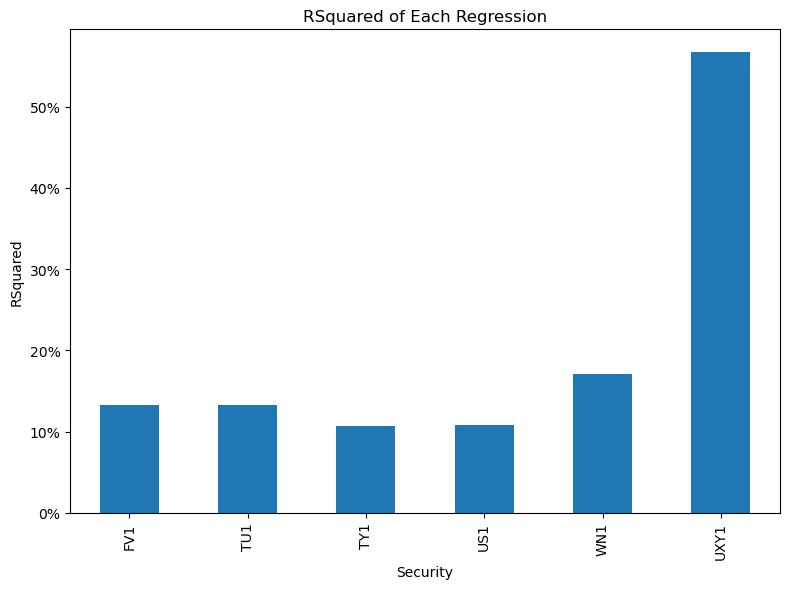

In [10]:
def plot_rsquared(models) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (pd.DataFrame(
        data = [model["model"].rsquared for model in models],
        index = [model["exog"] for model in models]).
        rename(columns = {0: "RSquared"}).
        plot(
            kind    = "bar",
            legend  = False,
            title   = "RSquared of Each Regression",
            ylabel  = "RSquared",
            xlabel  = "Security",
            ax      = axes))
    
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:,.0f}%'))
    plt.tight_layout()

plot_rsquared(models)

In [11]:
def prep_rtn() -> pd.DataFrame:

    df_rtn = (Regression().prep_regression().query(
        "-3 <= day <= -1")
        [["event", "date", "variable", "PX_bps"]])

    return df_rtn

df_rtn = prep_rtn()

In [12]:
def _get_predicted(df: pd.DataFrame, models: list) -> pd.DataFrame: 

    model  = [model for model in models if model["exog"] == df.name][0]["model"]
    df_out = (df.assign(
        predicted = model.predict()))

    return df_out

def get_predicted(models: list) -> pd.DataFrame: 

    df_pred = (Regression().prep_regression()[
        ["event", "variable"]].
        drop_duplicates().
        groupby("variable").
        apply(_get_predicted, models, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]))

    return df_pred

df_pred = get_predicted(models)

In [13]:
def get_backtest(df_pred: pd.DataFrame, df_rtn: pd.DataFrame) -> pd.DataFrame:

    df_backtest = (df_pred.merge(
        right = df_rtn, how = "inner", on = ["variable", "event"]).
        assign(signal_rtn = lambda x: np.sign(x.predicted) * x.PX_bps))

    return df_backtest

df_backtest = get_backtest(df_pred, df_rtn)

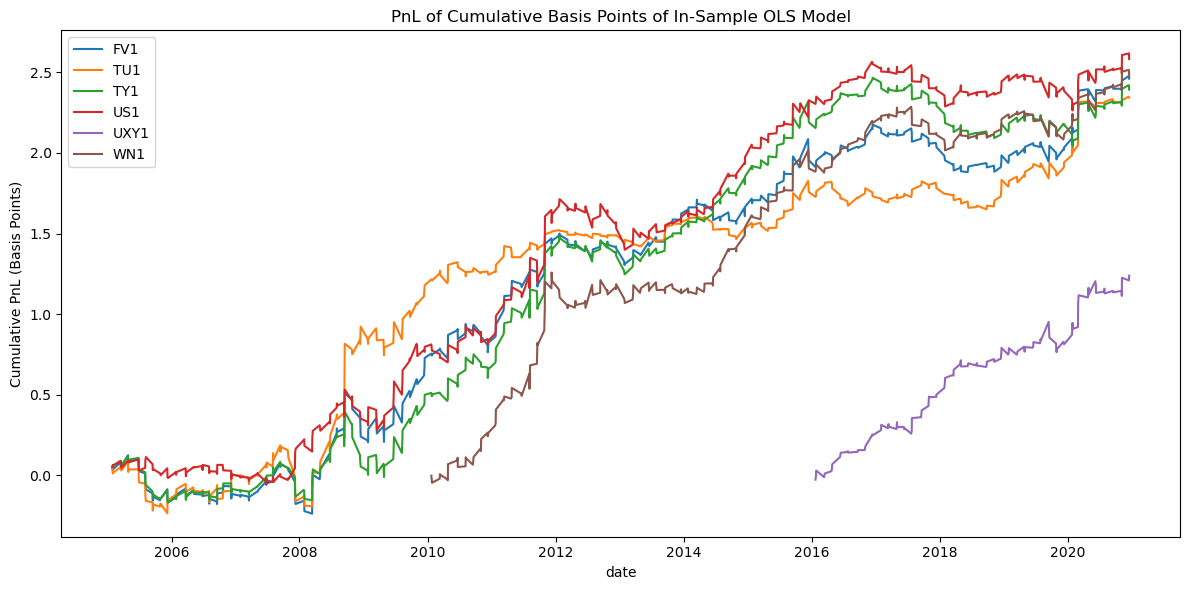

In [14]:
def plot_cumulative_rtn(df_backtest: pd.DataFrame) -> plt.Figure: 

    (df_backtest[
        ["variable", "date", "signal_rtn"]].
        rename(columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        cumsum().
        plot(
            ylabel  = "Cumulative PnL (Basis Points)",
            title   = "PnL of Cumulative Basis Points of In-Sample OLS Model",
            figsize = (12,6)))

    plt.tight_layout()

plot_cumulative_rtn(df_backtest)

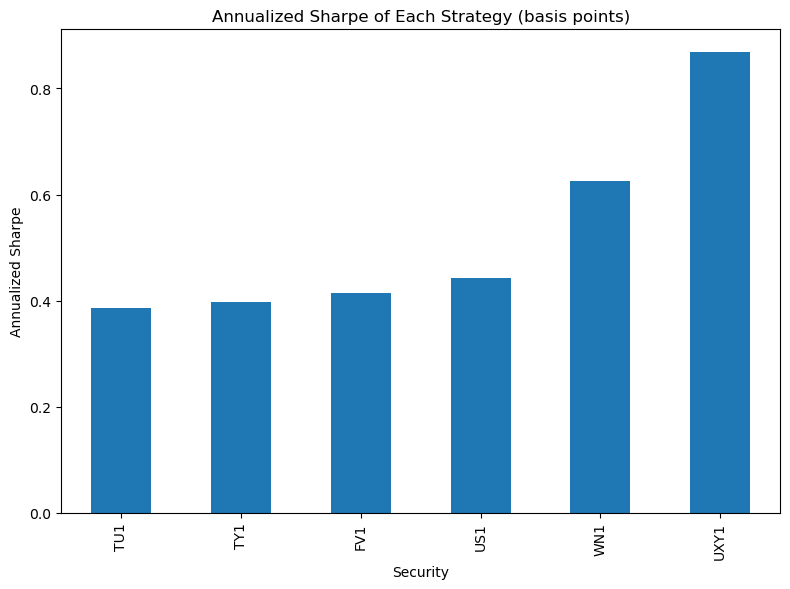

In [15]:
def plot_sharpe(df_backtest: pd.DataFrame) -> plt.Figure: 

    (df_backtest[
        ["variable", "signal_rtn"]].
        groupby("variable").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            kind    = "bar",
            legend  = False,
            xlabel  = "Security",
            ylabel  = "Annualized Sharpe",
            figsize = (8,6),
            title   = "Annualized Sharpe of Each Strategy (basis points)"))

    plt.tight_layout()

plot_sharpe(df_backtest)